- **Тип решаемой задачи:** сегментация;
- **Архитектура:** модель типа U-Net, энкодер - предобученный ResNet50, декодер - симметричная часть;
- **Метрика:** IoU;
- **Лосс:** комбинация из Dice, Focal и Boundry loss. Почему так: dice loss для борьбы с дисбалансом классов, все таки на снимке зачастую зданий меньше, чем земли, focal loss для уменьшения "важности" легких примеров, boundry loss для штрафов за ошибки на границах зданий. Веса в комбинации лоссов были подобраны эмпирически;
- **Обучение:** обучение заняло 42 эпохи, в ходе обучения менялся размер патчей, от 256х256 до 1024х1024;
- **Решение альтернативной задачи:** не проводилось (если речь идет о том, чтобы, например, сделать и сегментацию зданий, и детекцию);
- **Проверка на тестовой выборке:** проведена в конце данного ноутбука;
- **Ручная разметка тестовой выборки:** разметка была выполнена с помощью CVAT и предварительной разметки с помощью "вытаскивания" полигонов из самих снимков (т.к. .tif оказался с геометками);
- **Реализация демо-приложения:** выполнено на Streamlit, файл `webapp.py`;
- **Выводы по исследованию:** В целом, модель справляется неплохо, однако было бы интересно решить альтернативную задачу - детекцию. Была надежда на то, что постпроцессинг улучшит результат, но не вышло :)

### Сегментация зданий

In [10]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from src.dataset import PatchDataset
from src.model import BuildingSegmentationModel
from src.postprocessing import postprocess_mask

In [11]:
TRAIN_IMAGES_PATH = "../data/train/images"
TRAIN_GT_PATH = "../data/train/gt"

Поделим изображения на патчи

In [12]:
patch_size = 512
stride = 400
ds = PatchDataset(TRAIN_IMAGES_PATH, TRAIN_GT_PATH, patch_size=patch_size, stride=stride)
print(f'num of pathes: {len(ds)}\nsize: {patch_size}\nstride: {stride}')

num of pathes: 30420
size: 512
stride: 400


Посмотрим, какими получаются патчи на конкретном примере

In [13]:
img, gt, x, y, name = ds[100]

In [14]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

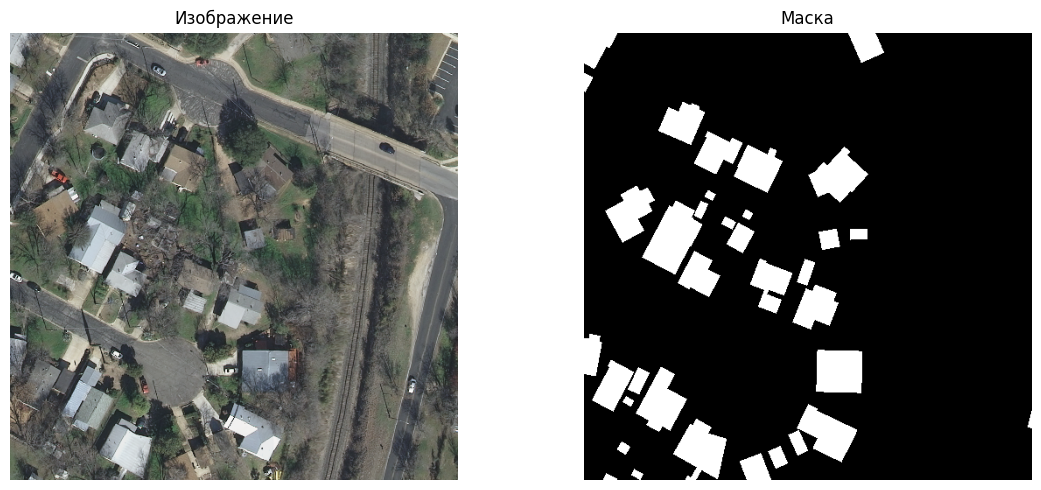

In [15]:
img_vis = inv_normalize(img).permute(1, 2, 0).clamp(0, 1).numpy()
gt_vis = gt.squeeze().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_vis)
plt.title("Изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gt_vis, cmap='gray')
plt.title("Маска")
plt.axis('off')

plt.tight_layout()
plt.show()

Посмотрим, как модель работала на разных эпохах

In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device: {DEVICE}')

device: cuda


In [17]:
def iou_score(pred_bin, target):
    pred_bin = (pred_bin > 0).astype(np.uint8)
    target = (target > 0).astype(np.uint8)
    
    intersection = (pred_bin & target).sum()
    union = pred_bin.sum() + target.sum() - intersection
    
    return (intersection + 1e-6) / (union + 1e-6)

In [18]:
model = BuildingSegmentationModel().to(DEVICE)
model.eval();

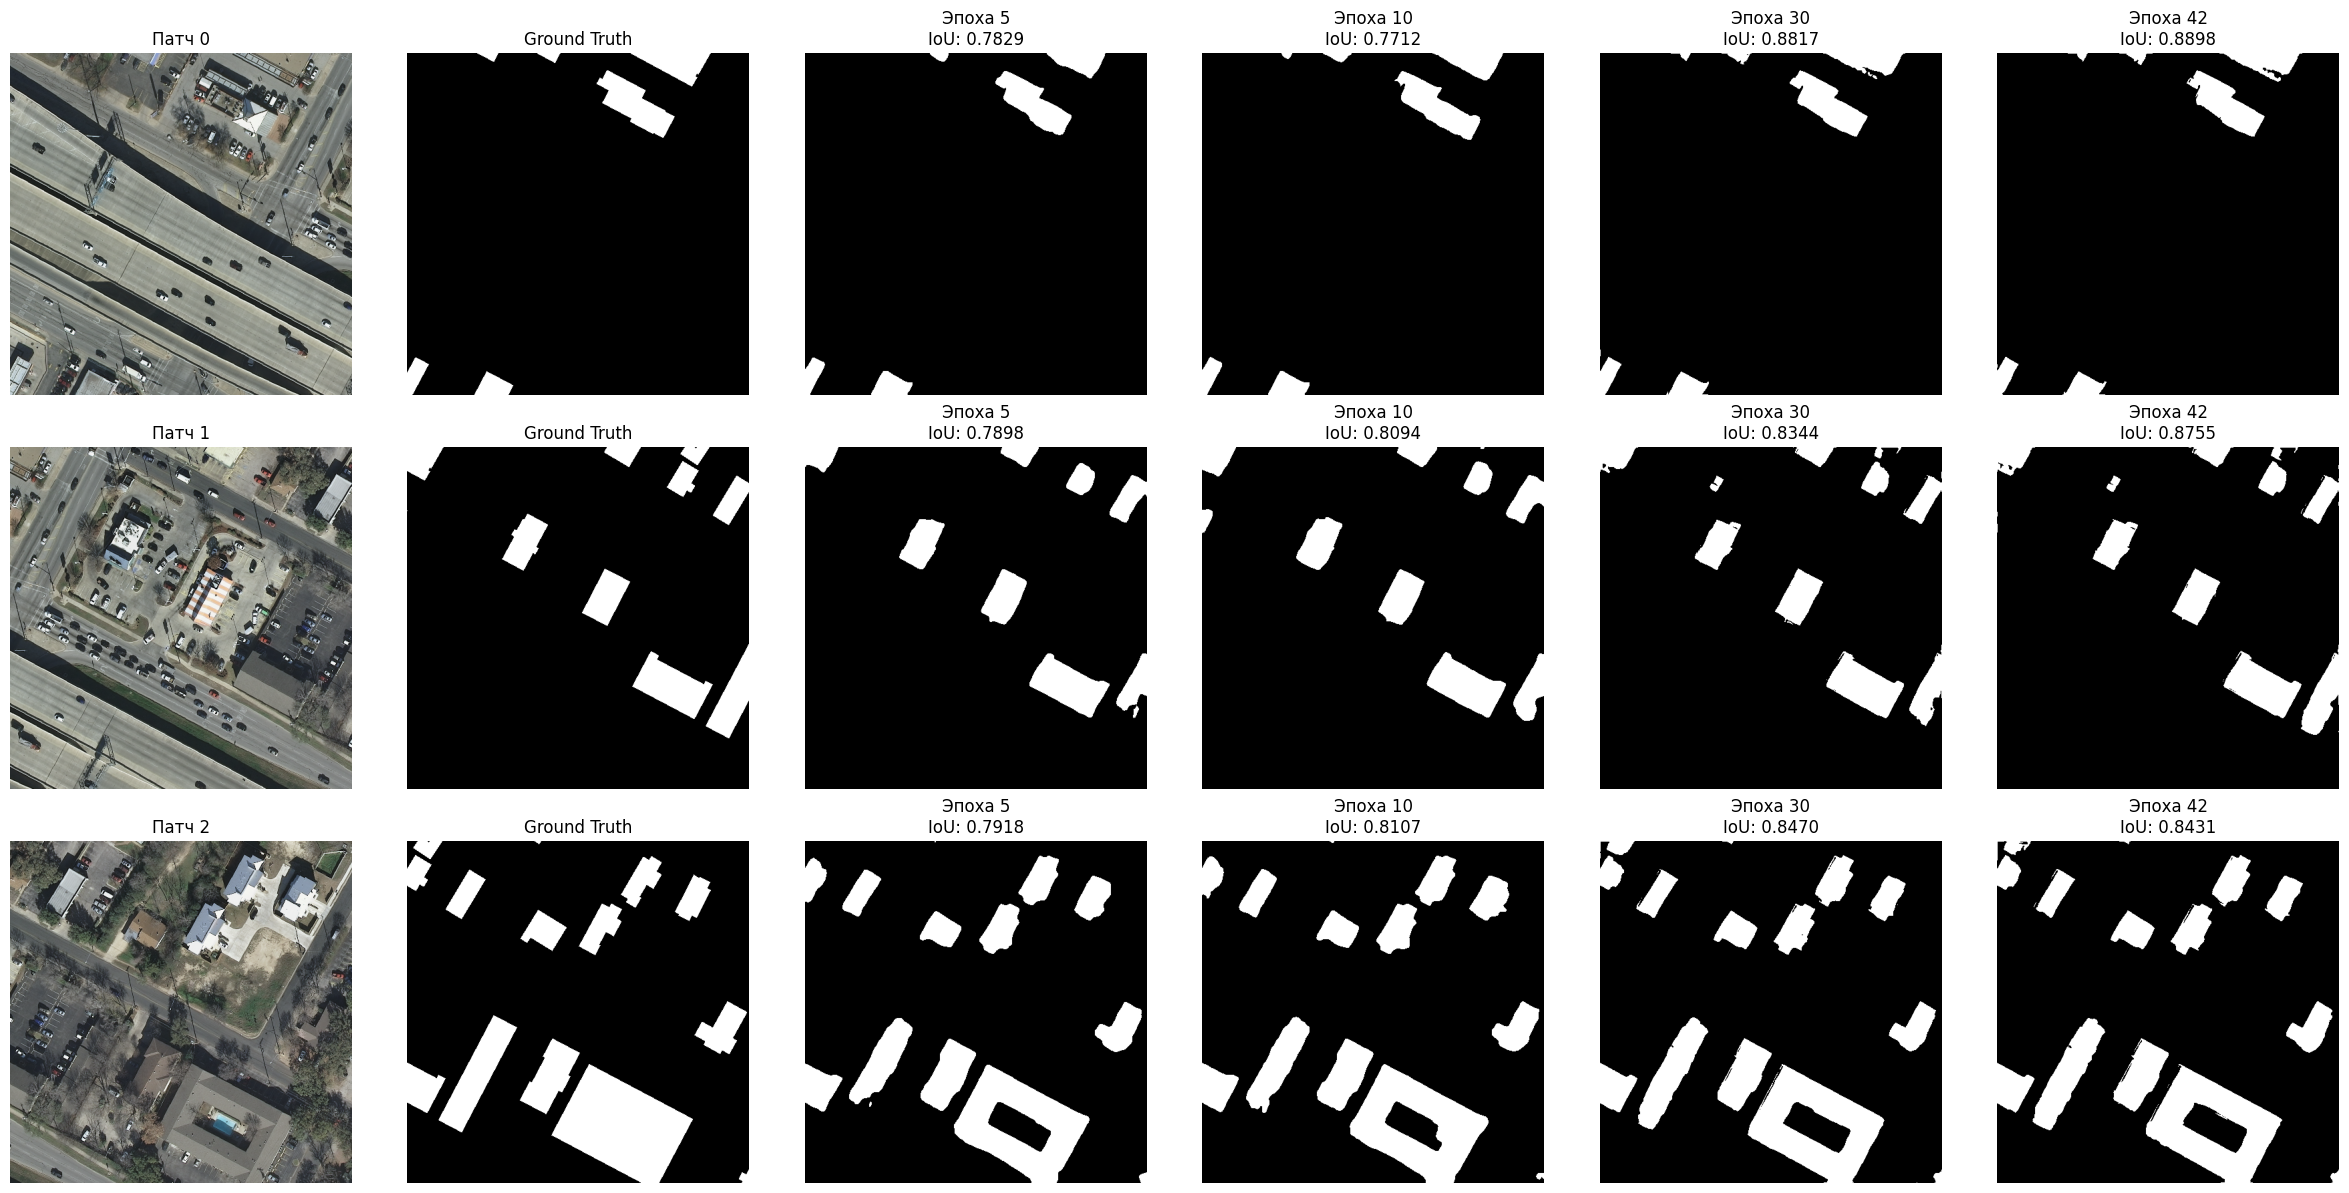

In [19]:
CHECKPOINT_DIR = "checkpoints"
EPOCHS = [5, 10, 30, 42]
PATCH_INDICES = [0, 1, 2]
THRESHOLD = 0.6

n_patches = len(PATCH_INDICES)
n_cols = len(EPOCHS) + 2

plt.figure(figsize=(4 * n_cols, 4 * n_patches))

for row_idx, patch_idx in enumerate(PATCH_INDICES):

    img, gt = ds[patch_idx][0], ds[patch_idx][1]
    img_vis = inv_normalize(img).permute(1, 2, 0).clamp(0, 1).numpy()
    gt_vis = gt.squeeze().numpy()
    

    plt.subplot(n_patches, n_cols, row_idx * n_cols + 1)
    plt.imshow(img_vis)
    plt.title(f"Патч {patch_idx}")
    plt.axis('off')
    

    plt.subplot(n_patches, n_cols, row_idx * n_cols + 2)
    plt.imshow(gt_vis, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
    for col_idx, epoch in enumerate(EPOCHS):
        checkpoint_path = f"../{CHECKPOINT_DIR}/model_epoch_{epoch}.pth"
        model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE, weights_only=True))
        
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(DEVICE)).squeeze().cpu().numpy()
            
            pred_binary = (pred > THRESHOLD).astype(np.uint8)
            gt_binary = (gt_vis > THRESHOLD).astype(np.uint8)

            iou = iou_score(pred_binary, gt_binary)
        
        plt.subplot(n_patches, n_cols, row_idx * n_cols + 3 + col_idx)
        plt.imshow(pred_binary, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Эпоха {epoch}\nIoU: {iou:.4f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

Очевидно, чем дальше по эпохам, тем лучше модель работает (IoU растет). В процессе обучения размер патчей менялся, первые 25 эпох модель обучалась на патчах 256х256, после чего 5 эпох с размерами 512х512, 6 эпох с размерами 768х768 и последние 6 эпох с размерами 1024х1024. Далее подробнее рассмотрим модель с весами на последней эпохе.

In [20]:
model.load_state_dict(torch.load("../weights/model_weights.pth", map_location=DEVICE, weights_only=True))
model.eval();

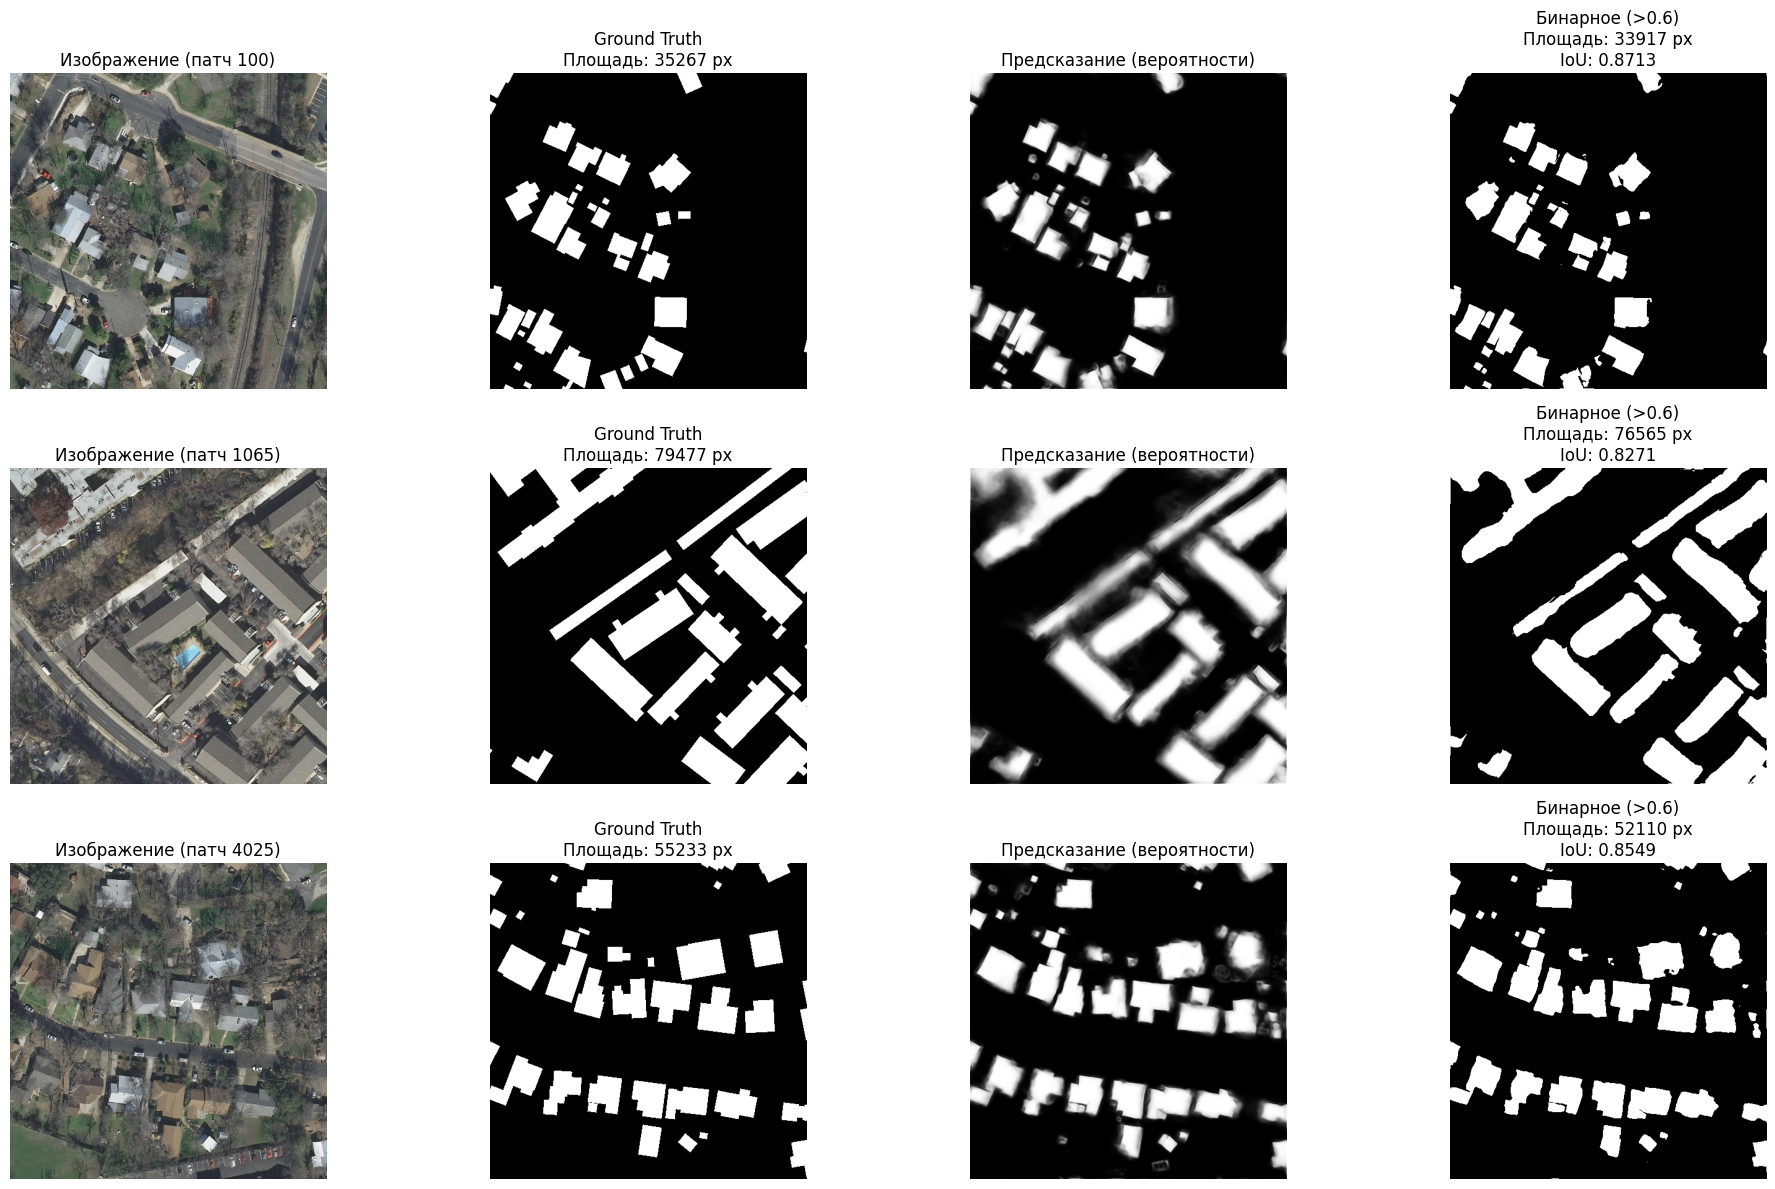

In [21]:
indices = [100, 1065, 4025]
n = len(indices)

plt.figure(figsize=(20, 4 * n))

for i, idx in enumerate(indices):
    result = ds[idx]
    img, gt = result[0], result[1]
    img_batch = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(img_batch).squeeze().cpu()

    img_vis = inv_normalize(img).permute(1, 2, 0).clamp(0, 1).numpy()
    gt_vis = gt.squeeze().numpy()
    pred_vis = pred.numpy()
    
    pred_prob = pred.numpy()
    pred_binary = (pred_prob > THRESHOLD).astype('uint8')

    area_gt_px = gt_vis.sum()
    area_pred_px = pred_binary.sum()

    iou_val = iou_score(pred_binary, gt_vis)

    plt.subplot(n, 4, i * 4 + 1)
    plt.imshow(img_vis)
    plt.title(f"Изображение (патч {idx})")
    plt.axis('off')

    plt.subplot(n, 4, i * 4 + 2)
    plt.imshow(gt_vis, cmap='gray')
    plt.title(f"Ground Truth\nПлощадь: {area_gt_px:.0f} px")
    plt.axis('off')

    plt.subplot(n, 4, i * 4 + 3)
    plt.imshow(pred_vis, cmap='gray', vmin=0, vmax=1)
    plt.title(f"Предсказание (вероятности)")
    plt.axis('off')

    plt.subplot(n, 4, i * 4 + 4)
    plt.imshow(pred_binary, cmap='gray')
    plt.title(f"Бинарное (>{THRESHOLD})\nПлощадь: {area_pred_px:.0f} px\nIoU: {iou_val:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

А что если не просто приводить маску к бинарному виду, а еще добавить постпроцессинг, по типу заполнения пустот в фигурах и т.д.? Посмотрим, как на IoU влияет постпроцессинг

In [15]:
import random

N_SAMPLES = 100
THRESHOLD = 0.6
MIN_AREA = 50
SEED = 42

random.seed(SEED)
indices = random.sample(range(len(ds)), min(N_SAMPLES, len(ds)))

ious_binary = []
ious_postprocessed = []

for idx in indices:
    img, gt = ds[idx][0], ds[idx][1]
    img_batch = img.unsqueeze(0).to(DEVICE)
    
    gt_np = gt.squeeze().cpu().numpy()
    gt_binary = (gt_np > 0.5).astype(np.uint8)

    with torch.no_grad():
        pred_prob = model(img_batch).squeeze().cpu().numpy()

    pred_binary = (pred_prob > THRESHOLD).astype(np.uint8)
    iou_bin = iou_score(pred_binary, gt_binary)

    pred_pp, _ = postprocess_mask(pred_prob, threshold=THRESHOLD, min_area=MIN_AREA)
    iou_pp = iou_score(pred_pp, gt_binary)

    ious_binary.append(iou_bin)
    ious_postprocessed.append(iou_pp)

ious_binary = np.array(ious_binary)
ious_postprocessed = np.array(ious_postprocessed)
diffs = ious_postprocessed - ious_binary

mean_diff = diffs.mean()
std_diff = diffs.std()
improved = (diffs > 0).sum()
worse = (diffs < 0).sum()
same = (diffs == 0).sum()


print(f"Среднее изменение IoU ± СКО: {mean_diff:.4f} ± {std_diff:.4f}")
print(f"Медиана изменения IoU: {np.median(diffs):.4f}")

print(f"\nИз {N_SAMPLES} патчей:")
print(f"\tУлучшилось: {improved}")
print(f"\tУхудшилось: {worse}")
print(f"\tБез изменений: {same}")

Среднее изменение IoU ± СКО: 0.0231 ± 0.1732
Медиана изменения IoU: -0.0032

Из 100 патчей:
	Улучшилось: 33
	Ухудшилось: 55
	Без изменений: 12


Итого, постпроцессинг зачастую ухудшает IoU (После данного "исследования" было проведено несколько итераций изменения постпроцессинга, однако результат не изменился, из-за чего было принято решение отказаться от него, но файл с кодом оставил).

### Детекция автомобилей для определения масштаба снимка

Так как правилами разрешено использовать предобученные модели YOLO от ultralytics, возьмем yolo26x-obb, посмотрим, как работает на наших данных

0: 1024x1024 2 large vehicles, 14 small vehicles, 70.3ms
Speed: 19.2ms preprocess, 70.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)


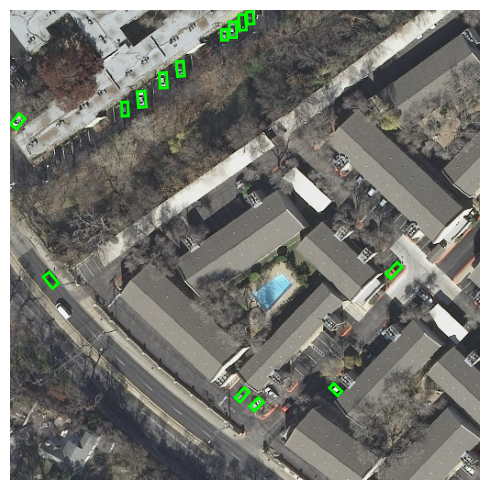

In [22]:
from ultralytics import YOLO
from matplotlib.patches import Polygon

model_yolo = YOLO("../weights/yolo26x-obb.pt")

img, gt, x, y, name = ds[1065]

img_vis = inv_normalize(img).permute(1, 2, 0).clamp(0, 1).numpy()
gt_vis = gt.squeeze().numpy()

img_uint8 = (img_vis * 255).astype(np.uint8)

results = model_yolo(img_uint8, conf=0.1, iou=0.45)

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(img_vis)

for r in results:
    if r.obb is not None:
        for obb in r.obb:
            cls_id = int(obb.cls.item())
            if cls_id == 10:
                corners = obb.xyxyxyxy[0].cpu().numpy()
                
                polygon = Polygon(corners, closed=True, edgecolor='lime', facecolor='none', linewidth=2)
                ax.add_patch(polygon)

ax.axis('off')
plt.tight_layout()
plt.show()

### Тест работы модели на размеченных вручную снимках

Для теста модели вручную (через CVAT) было размечено 18 снимков, каждый из которых после был нарезан на части, пустые части были удалены (по поводу нарезки: размечать, условно, 30+ снимков очень долго, разметка 18 снимков, даже с учетом кооперации (которая разрешена) занимала очень много времени, в среднем на снимок уходило 2 часа, на сложные порядка 3-3.5 часов)

In [23]:
import tifffile
from pathlib import Path

results = []
image_dir = "../manual_data/test_sliced/images"
gt_dir = "../manual_data/test_sliced/gt"

test_ds = PatchDataset(image_dir=image_dir, gt_dir=gt_dir, patch_size=512, stride=400)

from collections import defaultdict
patches_by_image = defaultdict(list)
for i, (_, _, x, y, name) in enumerate(test_ds):
    patches_by_image[name].append(i)

for img_name, indices in patches_by_image.items():
    full_img = test_ds.patches[indices[0]][0]
    h, w = tifffile.imread(str(full_img)).shape[:2]

    prob_map = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)

    for idx in indices:
        img_patch, gt_patch, x, y, _ = test_ds[idx]
        with torch.no_grad():
            pred = model(img_patch.unsqueeze(0).to(DEVICE)).squeeze().cpu().numpy()
        ph, pw = pred.shape
        y_end = min(y + ph, h)
        x_end = min(x + pw, w)
        pred = pred[:y_end - y, :x_end - x]
        prob_map[y:y_end, x:x_end] += pred
        count_map[y:y_end, x:x_end] += 1

    prob_map /= np.maximum(count_map, 1)
    pred_binary = (prob_map > 0.5).astype(np.uint8)

    gt_path = Path(gt_dir) / (Path(img_name).stem + ".tif")
    gt_full = tifffile.imread(str(gt_path))
    gt_binary = (gt_full > 0).astype(np.uint8)

    iou_val = iou_score(pred_binary, gt_binary)
    results.append({'image': img_name, 'iou': iou_val})
    print(f"{img_name}: IoU = {iou_val:.4f}")

if results:
    ious = [r['iou'] for r in results]
    print("\n" + "="*50)
    print(f"Средний IoU: {np.mean(ious):.4f}")

bellingham10_0.tif: IoU = 0.7453
bellingham10_1.tif: IoU = 0.8452
bellingham10_2.tif: IoU = 0.7644
bellingham10_3.tif: IoU = 0.8173
bellingham14_0.tif: IoU = 0.8100
bellingham14_1.tif: IoU = 0.7090
bellingham14_2.tif: IoU = 0.7223
bellingham14_3.tif: IoU = 0.7061
bellingham16_0.tif: IoU = 0.6872
bellingham16_1.tif: IoU = 0.7435
bellingham16_2.tif: IoU = 0.7245
bellingham16_3.tif: IoU = 0.8176
bellingham18_0.tif: IoU = 0.6166
bellingham18_1.tif: IoU = 0.7907
bellingham18_2.tif: IoU = 0.7009
bellingham26_0.tif: IoU = 0.6942
bellingham26_1.tif: IoU = 0.8585
bellingham26_2.tif: IoU = 0.7391
bellingham26_3.tif: IoU = 0.8657
bellingham28_0.tif: IoU = 0.8482
bellingham28_1.tif: IoU = 0.7344
bellingham28_2.tif: IoU = 0.7650
bellingham28_3.tif: IoU = 0.7086
bellingham2_0.tif: IoU = 0.7456
bellingham2_1.tif: IoU = 0.7264
bellingham2_2.tif: IoU = 0.6742
bellingham2_3.tif: IoU = 0.7183
bellingham3_0.tif: IoU = 0.7313
bellingham3_1.tif: IoU = 0.6829
bellingham4_0.tif: IoU = 0.7775
bellingham4_1.tif